In [8]:
import numpy as np
import pandas as pd
import datetime
import unicodedata
import statsapi

from data_scraper import MLB_Scrape
from pybaseball import pitching_stats, playerid_lookup

# Level 1 imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    mean_squared_error, r2_score
)

# Level 2 imports
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Level 3 imports
import pymc as pm

# Meta imports
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


def train_pitch_level_models(df: pd.DataFrame):
    df = df.copy()
    df['is_swing_bin'] = df['is_swing'].fillna(False).astype(int)

    num_cols = [
        'start_speed','end_speed','extension','spin_rate',
        'pfxx','pfxz','vx0','vy0','vz0','sz_top','sz_bot'
    ]
    cat_cols = ['pitch_type','batter_hand','pitcher_hand']
    feats    = num_cols + cat_cols

    # ── Swing classifier tuning ──
    swing_pipe = RandomizedSearchCV(
        Pipeline([
            ('pre', ColumnTransformer([
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
            ])),
            ('clf', RandomForestClassifier(random_state=42))
        ]),
        {
            'clf__n_estimators': [100,200,300],
            'clf__max_depth':    [None,10,20,30],
            'clf__min_samples_split': [2,5,10]
        },
        n_iter=8, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42
    )
    Xs, ys = df[feats], df['is_swing_bin']
    Xs_tr, Xs_v, ys_tr, ys_v = train_test_split(
        Xs, ys, stratify=ys, test_size=0.2, random_state=42
    )
    swing_pipe.fit(Xs_tr, ys_tr)

    # ── Whiff classifier tuning ──
    swings = df[df['is_swing_bin']==1]
    whiff_pipe = RandomizedSearchCV(
        Pipeline([
            ('pre', ColumnTransformer([
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
            ])),
            ('clf', RandomForestClassifier(random_state=42))
        ]),
        {
            'clf__n_estimators': [100,200,300],
            'clf__max_depth':    [None,10,20],
            'clf__min_samples_leaf': [1,2,4]
        },
        n_iter=8, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42
    )
    Xw = swings[feats]
    yw = swings['is_whiff'].fillna(False).astype(int)
    Xw_tr, Xw_v, yw_tr, yw_v = train_test_split(
        Xw, yw, stratify=yw, test_size=0.2, random_state=42
    )
    whiff_pipe.fit(Xw_tr, yw_tr)

    # ── Exit‑velocity regressor tuning ──
    hits = swings[~swings['is_whiff'].fillna(False)].dropna(subset=['launch_speed'])
    exit_pipe = RandomizedSearchCV(
        Pipeline([
            ('pre', ColumnTransformer([
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
            ])),
            ('reg', RandomForestRegressor(random_state=42))
        ]),
        {
            'reg__n_estimators': [100,200,300],
            'reg__max_depth':    [None,10,20],
            'reg__min_samples_split': [2,5,10]
        },
        n_iter=8, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
    )
    Xh, yh = hits[feats], hits['launch_speed']
    Xh_tr, Xh_v, yh_tr, yh_v = train_test_split(
        Xh, yh, test_size=0.2, random_state=42
    )
    exit_pipe.fit(Xh_tr, yh_tr)

    # Level 1 metrics
    print("== Level 1 Metrics ==")
    ys_pred = swing_pipe.predict(Xs_v)
    ys_prob = swing_pipe.predict_proba(Xs_v)[:,1]
    print("Swing:   Acc =", accuracy_score(ys_v, ys_pred),
          "AUC =", roc_auc_score(ys_v, ys_prob))
    print(classification_report(ys_v, ys_pred))

    yw_pred = whiff_pipe.predict(Xw_v)
    yw_prob = whiff_pipe.predict_proba(Xw_v)[:,1]
    print("Whiff:   Acc =", accuracy_score(yw_v, yw_pred),
          "AUC =", roc_auc_score(yw_v, yw_prob))
    print(classification_report(yw_v, yw_pred))

    yh_pred = exit_pipe.predict(Xh_v)
    print("ExitVel: MSE =", mean_squared_error(yh_v, yh_pred),
          "R² =", r2_score(yh_v, yh_pred))

    def compute_pitch_score(df_in: pd.DataFrame) -> pd.Series:
        d = df_in.copy()
        d['is_swing_bin'] = d['is_swing'].fillna(False).astype(int)
        Xn = d[feats]
        p_s = swing_pipe.predict_proba(Xn)[:,1]
        p_w = np.zeros(len(d))
        m   = d['is_swing_bin']==1
        if m.any():
            p_w[m] = whiff_pipe.predict_proba(Xn[m])[:,1]
        e_e = np.zeros(len(d))
        hm  = m & (p_w<1)
        if hm.any():
            e_e[hm] = exit_pipe.predict(Xn[hm])
        return pd.Series(p_s*(1-p_w)*e_e, index=d.index)

    return compute_pitch_score


def prepare_game_sequences(df, feats, target, seq_len=5):
    X, y, idxs = [], [], []
    for (_, g) in df.groupby(['Name','Season']):
        g = g.sort_values('game_date')
        F, T = g[feats].values, g[target].values
        for i in range(len(g)-seq_len):
            X.append(F[i:i+seq_len])
            y.append(T[i+seq_len])
            idxs.append(g.index[i+seq_len])
    return np.array(X), np.array(y), idxs


def tune_game_level_lstm(Xtr, ytr, Xv, yv, seq_len, n_feat):
    def build_model(hp):
        m = models.Sequential([
            layers.Masking(0., input_shape=(seq_len,n_feat)),
            layers.LSTM(
                units=hp.Choice('units',[16,32,64]),
                dropout=hp.Choice('dropout',[0.0,0.2])
            ),
            layers.Dense(1)
        ])
        m.compile(
            optimizer=Adam(learning_rate=hp.Choice('lr',[1e-3,1e-4])),
            loss='mse'
        )
        return m

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=8,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name='cy_model'
    )
    tuner.search(Xtr, ytr, epochs=20, validation_data=(Xv, yv), verbose=0)
    best = tuner.get_best_models(1)[0]
    mse  = best.evaluate(Xv, yv, verbose=0)
    print(f"== Level 2 LSTM val MSE: {mse:.4f} ==")
    return best


def fit_bayesian_season_model(df):
    pitchers = df['pitcher'].unique()
    idx      = pd.Categorical(df['pitcher'], categories=pitchers).codes
    with pm.Model() as m:
        mu  = pm.Normal('mu',0,1)
        sd  = pm.HalfNormal('sd',1)
        a   = pm.Normal('a',mu=mu,sigma=sd,shape=len(pitchers))
        eps = pm.HalfCauchy('eps',1)
        pm.Normal('obs', mu=a[idx], sigma=eps, observed=df['metric'])
        idata = pm.sample(1000, tune=1000, cores=2, target_accept=0.9)
    return pitchers, idata.posterior['a'].mean(dim=('chain','draw')).values


def train_meta_pipeline(meta_df: pd.DataFrame):
    Xm = meta_df[['pitch_score_mean','rbi_pred_mean','bayes_effect']].values
    Ys = meta_df['winner_flag'].values
    pipe = Pipeline([
        ('imp', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(solver='liblinear'))
    ])
    gs = GridSearchCV(pipe, {'clf__C':[0.01,0.1,1,10]}, cv=5, scoring='roc_auc')
    gs.fit(Xm, Ys)

    yp = gs.predict(Xm)
    pp = gs.predict_proba(Xm)[:,1]
    print("== Meta-model Performance ==")
    print("Acc =", accuracy_score(Ys, yp), "AUC =", roc_auc_score(Ys, pp))
    return gs.best_estimator_


def predict_cy_young(pipe, l1, l2, l3):
    Xm = np.vstack([l1, l2, l3]).T
    return pipe.predict_proba(Xm)[:,1]


def get_mlbam_id(name: str) -> int:
    nm = unicodedata.normalize("NFKD", name).encode("ascii","ignore").decode()
    parts = nm.split()
    first, last = parts[0], parts[-1]
    try:
        df = playerid_lookup(last, first).dropna(subset=['key_mlbam'])
        return int(df.iloc[0]['key_mlbam'])
    except:
        res = statsapi.lookup_player(name)
        if res:
            return int(res[0]['id'])
    raise ValueError(f"No MLBAM ID for {name!r}")


if __name__ == '__main__':
    # Historical training
    pitch_df   = pd.read_csv('pitch_level.csv', parse_dates=['game_date'])
    game_df    = pd.read_csv('game_level.csv', parse_dates=['game_date'])
    season_tot = pd.read_csv('season_totals.csv')
    labels_df  = pd.read_csv('cy_young_labels.csv')  # Name,Season,winner_flag

    # Level 1
    compute_score = train_pitch_level_models(pitch_df)
    pitch_df['pitch_score'] = compute_score(pitch_df)

    # Level 2 prep
    agg = (
        pitch_df
        .groupby(['game_id','game_date','Name','Season'])['pitch_score']
        .mean().reset_index()
        .rename(columns={'pitch_score':'pitch_score_mean'})
    )
    game_df = game_df.merge(agg,
                            on=['game_id','game_date','Name','Season'])

    # Level 2
    feats, seq_len = ['pitch_score_mean'], 5
    X, y, idxs = prepare_game_sequences(game_df, feats, 'rbi_mean', seq_len)
    Xtr, Xv2, ytr, yv2 = train_test_split(X, y, test_size=0.2, random_state=42)
    lstm = tune_game_level_lstm(Xtr, ytr, Xv2, yv2, seq_len, len(feats))
    preds = lstm.predict(X).flatten()
    game_df['rbi_pred'] = np.nan
    game_df.loc[idxs, 'rbi_pred'] = preds

    # Level 3
    bayes_df = (
        game_df[['Name','Season','rbi_pred']]
        .rename(columns={'Name':'pitcher','rbi_pred':'metric'})
    )
    bayes_pitchers, bayes_a_mean = fit_bayesian_season_model(bayes_df)
    season_tot['bayes_effect'] = season_tot['Name'].map(
        dict(zip(bayes_pitchers, bayes_a_mean))
    )

    # Meta
    p_seas = (
        pitch_df
        .groupby(['Name','Season'])['pitch_score']
        .mean().reset_index()
        .rename(columns={'pitch_score':'pitch_score_mean'})
    )
    r_seas = (
        game_df
        .groupby(['Name','Season'])['rbi_pred']
        .mean().reset_index()
        .rename(columns={'rbi_pred':'rbi_pred_mean'})
    )
    meta_df = (
        season_tot
        .merge(p_seas, on=['Name','Season'])
        .merge(r_seas, on=['Name','Season'])
        .merge(labels_df, on=['Name','Season'])
    )
    meta_pipeline = train_meta_pipeline(meta_df)

    # — Scrape & predict current season —
    CURRENT_YEAR = datetime.date.today().year
    season_cur   = pitching_stats(CURRENT_YEAR)
    season_cur['Season'] = CURRENT_YEAR

    scraper = MLB_Scrape()
    pitch_cur_list = []
    for name in season_cur['Name']:
        try:
            pid = get_mlbam_id(name)
        except ValueError:
            continue
        games = scraper.get_player_games_list(
            player_id=pid,
            season=CURRENT_YEAR,
            start_date=f"{CURRENT_YEAR}-03-01",
            end_date=f"{CURRENT_YEAR}-11-30",
            sport_id=1,
            game_type=['R'],
            pitching=True
        )
        if not games:
            continue
        jsons = scraper.get_data(game_list_input=games)
        df_raw = scraper.get_data_df(data_list=jsons)
        df = getattr(df_raw, "to_pandas", lambda: df_raw)()
        df = df[df['pitcher_id']==pid].copy()
        df['Name'], df['Season'] = name, CURRENT_YEAR
        pitch_cur_list.append(df)

    if pitch_cur_list:
        pitch_df_cur = pd.concat(pitch_cur_list, ignore_index=True)
        pitch_df_cur['pitch_score'] = compute_score(pitch_df_cur)

        game_df_cur = (
            pitch_df_cur
            .groupby(['game_id','game_date','Name','Season'])['rbi']
            .mean().reset_index()
            .rename(columns={'rbi':'rbi_mean'})
        )
        agg_cur = (
            pitch_df_cur
            .groupby(['game_id','game_date','Name','Season'])['pitch_score']
            .mean().reset_index()
            .rename(columns={'pitch_score':'pitch_score_mean'})
        )
        game_df_cur = game_df_cur.merge(
            agg_cur,
            on=['game_id','game_date','Name','Season']
        )

        # ensure rbi_pred exists before grouping
        game_df_cur['rbi_pred'] = np.nan
        Xc, _, idxs_c = prepare_game_sequences(game_df_cur, feats, 'rbi_mean', seq_len)
        if len(Xc) > 0:
            rbi_c = lstm.predict(Xc).flatten()
            game_df_cur.loc[idxs_c, 'rbi_pred'] = rbi_c

        season_cur['bayes_effect'] = season_cur['Name'].map(
            dict(zip(bayes_pitchers, bayes_a_mean))
        ).fillna(bayes_a_mean.mean())

        rbi_cur_seas = (
            game_df_cur
            .groupby(['Name','Season'])['rbi_pred']
            .mean().reset_index()
            .rename(columns={'rbi_pred':'rbi_pred_mean'})
        )
        default_rbi = r_seas['rbi_pred_mean'].mean()
        rbi_cur_seas['rbi_pred_mean'] = rbi_cur_seas['rbi_pred_mean'].fillna(default_rbi)

        pitch_cur_seas = (
            pitch_df_cur
            .groupby(['Name','Season'])['pitch_score']
            .mean().reset_index()
            .rename(columns={'pitch_score':'pitch_score_mean'})
        )

        season_cur = (
            season_cur
            .merge(pitch_cur_seas, on=['Name','Season'])
            .merge(rbi_cur_seas,    on=['Name','Season'])
        )

        L1c = season_cur['pitch_score_mean'].values
        L2c = season_cur['rbi_pred_mean'].values
        L3c = season_cur['bayes_effect'].values

        season_cur['cywin_prob'] = predict_cy_young(meta_pipeline, L1c, L2c, L3c)
        print(
            season_cur[['Name','Season','cywin_prob']]
            .sort_values('cywin_prob', ascending=False)
        )


/tmp/ipykernel_81723/2847549123.py:246: DtypeWarning: Columns (15,16,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  pitch_df   = pd.read_csv('pitch_level.csv', parse_dates=['game_date'])
/tmp/ipykernel_81723/2847549123.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_swing_bin'] = df['is_swing'].fillna(False).astype(int)
/tmp/ipykernel_81723/2847549123.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yw = swings['is_whiff'].fillna(False).astype(int)
/tmp/ipykernel_81723/2847549123.py:93: FutureWarning: D

== Level 1 Metrics ==
Swing:   Acc = 0.7956346845024159 AUC = 0.8745557166341422
              precision    recall  f1-score   support

           0       0.82      0.77      0.80     21523
           1       0.78      0.82      0.80     20490

    accuracy                           0.80     42013
   macro avg       0.80      0.80      0.80     42013
weighted avg       0.80      0.80      0.80     42013

Whiff:   Acc = 0.7606637384089799 AUC = 0.7398397992679298
              precision    recall  f1-score   support

           0       0.77      0.95      0.85     14669
           1       0.70      0.28      0.40      5821

    accuracy                           0.76     20490
   macro avg       0.73      0.62      0.62     20490
weighted avg       0.75      0.76      0.72     20490

ExitVel: MSE = 196.46191257028107 R² = 0.09169048998419171


/tmp/ipykernel_81723/2847549123.py:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d['is_swing_bin'] = d['is_swing'].fillna(False).astype(int)


Reloading Tuner from lstm_tuning/cy_model/tuner0.json


/home/charlesbenfer/CY_Plus/.venv/lib/python3.12/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/charlesbenfer/CY_Plus/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


== Level 2 LSTM val MSE: 0.0094 ==
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/charlesbenfer/CY_Plus/.venv/lib/python3.12/site-packages/pymc/model/core.py:1311: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd, a, eps, obs_unobserved]


/home/charlesbenfer/CY_Plus/.venv/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


== Meta-model Performance ==
Acc = 0.9285714285714286 AUC = 0.6175213675213675
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.25iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.88iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.75iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.01iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 15.42iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.75iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.16iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.26iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.71iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.38iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.91iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.34iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.34iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.33iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.67iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.40iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.75iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.85iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.01iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.16iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.57iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.04iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.69iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.74iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.23iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 14.90iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.97iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.28iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.21iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.78iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.92iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.11iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.19iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 15.13iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.09iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.85iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.05iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.78iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.65iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.54iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.82iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.84iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.12iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.62iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.67iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 11.76iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.23iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 15.57iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.99iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 15.75iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.96iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.32iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.34iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.64iteration/s]


Converting Data to Dataframe.
No pitching games found for player 112116 in season 2025
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 12.00iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 14.09iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 26.81iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.97iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 17.10iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 12.45iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.24iteration/s]


Converting Data to Dataframe.
No pitching games found for player 656814 in season 2025
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.92iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 15.21iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.14iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.28iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 14.92iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.02iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 15.32iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.67iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 15.23iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.41iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 14.69iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.02iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 4/4 [00:00<00:00, 13.62iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 16.39iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.04iteration/s]


Converting Data to Dataframe.
This May Take a While. Progress Bar shows Completion of Data Retrieval.


Processing: 100%|██████████| 5/5 [00:00<00:00, 18.01iteration/s]
/tmp/ipykernel_81723/2847549123.py:135: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d['is_swing_bin'] = d['is_swing'].fillna(False).astype(int)


Converting Data to Dataframe.
                     Name  Season  cywin_prob
20          Hunter Greene    2025    0.077411
47  Spencer Schwellenbach    2025    0.067181
32         Framber Valdez    2025    0.041975
5             Cole Ragans    2025    0.036838
48          Luis Severino    2025    0.036777
..                    ...     ...         ...
53           Carlos Rodon    2025    0.002623
15            Clay Holmes    2025    0.002415
57         Tyler Anderson    2025    0.002197
26           Michael King    2025    0.002078
19         Freddy Peralta    2025    0.001323

[77 rows x 3 columns]


In [9]:
season_cur[season_cur['Name']=='Carlos Rodon']

,IDfg,Season,Name,Team,Age,W,L,WAR,ERA,G,...,Stuff+,Location+,Pitching+,Stf+ FO,Loc+ FO,Pit+ FO,bayes_effect,pitch_score_mean,rbi_pred_mean,cywin_prob
53,16137,2025,Carlos Rodon,NYY,32,2,3,0.2,4.34,5,...,105,95,101,NaN,NaN,NaN,0.081342,12.069914,0.081135,0.002623


Text(0.5, 1.0, 'Distribution of Cy Young Contenders')

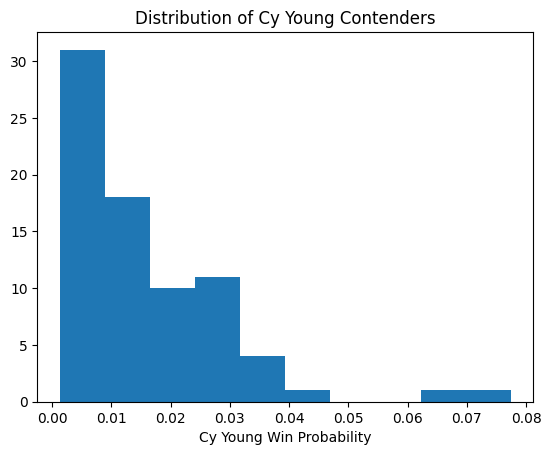

In [11]:
import matplotlib.pyplot as plt

plt.hist(season_cur['cywin_prob'])
plt.xlabel('Cy Young Win Probability')
plt.title('Distribution of Cy Young Contenders')